In [3]:
import os
import torch

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.io as sio
import scipy.stats as stats
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import tqdm
import pingouin as pg

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [4]:
fc_path = '/data5/open_data/ABCD/rest/derivatives/abcd-hcp-pipeline/'
white_subs = pd.read_csv('/users/kje/data/IG/ABCD/white_sbj.csv')['0']
diag = pd.read_csv('/users/hjd/data/ABCD_table/KSADS_Combined_21diag.csv', delimiter = '\t')
rest_subs = os.listdir(fc_path)
ADHD_subs = diag['subjectkey'][diag['ADHD']==1]
white_list = []
for i in white_subs:
    a='sub-' + i[:4] + i[5:]
    white_list.append(a)
ADHD_list = []
for i in ADHD_subs:
    b='sub-' + i[:4] + i[5:]
    ADHD_list.append(b)

In [5]:
white_set = set(rest_subs) & set(white_list)
adhd_set = set(rest_subs) & set(white_list) & set(ADHD_list)
control_set = white_set.difference(adhd_set)
print('White subs: ', len(white_set))

data_list = []

for i, sub in enumerate(tqdm.tqdm(white_set)):
    if not os.path.exists(fc_path + sub + '/ses-baselineYear1Arm1/func/' + sub + '_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries_thresh-fd0p2mm_censor-belowthresh_conndata-network_connectivity.pconn.nii'):
        continue
    if not os.path.exists(fc_path + sub + '/ses-baselineYear1Arm1/func/' + sub + '_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii'):
        continue
    fc_map = nib.load(fc_path + sub + '/ses-baselineYear1Arm1/func/' + sub + '_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries_thresh-fd0p2mm_censor-belowthresh_conndata-network_connectivity.pconn.nii')
    if np.isnan(fc_map.get_fdata()).any():
        continue
    fc_map_zs = stats.zscore(np.tanh(fc_map.get_fdata()), axis=None)
    idx = np.where((fc_map_zs > 2) | (fc_map_zs < -2))
    a=idx[0]
    b=idx[1]
    edge_index = torch.LongTensor(np.vstack((a,b)))
    censor = pd.read_csv(fc_path + sub + '/ses-baselineYear1Arm1/func/' + sub + '_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries_thresh-fd0p2mm_censor-belowthresh_conndata-network_censor.txt', delimiter='\t', low_memory=False)
    mask = censor['0'].values
    mask = mask.astype(bool)
    timeseries = nib.load(fc_path + sub + '/ses-baselineYear1Arm1/func/' + sub + '_ses-baselineYear1Arm1_task-rest_bold_atlas-Gordon2014FreeSurferSubcortical_desc-filtered_timeseries.ptseries.nii')
    timeseries = timeseries.get_fdata()[1:, :]
    if len(timeseries) != len(mask):
        continue
    masked = timeseries[mask, :]
    df = pd.DataFrame(masked)
    x=torch.Tensor(df.pcorr().values)
    if sub in adhd_set:
        y = torch.tensor([1])
    else:
        y = torch.tensor([0])
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

White subs:  4001


100%|███████████████████████████████████████████████████████████| 4001/4001 [1:21:29<00:00,  1.22s/it]


In [6]:
for i, a in enumerate(data_list):
    if torch.isnan(a.x).any():
        print('index : ', i)

In [ ]:
data_list[3457].edge_index

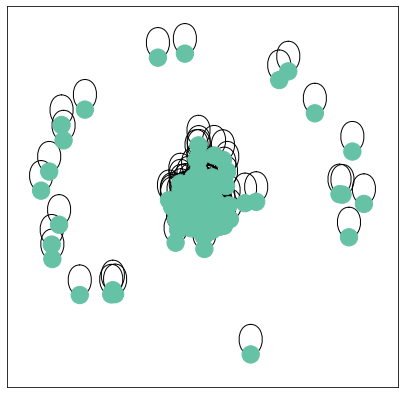

In [7]:
from torch_geometric.utils import to_networkx

G = to_networkx(data_list[706], to_undirected=True)
visualize_graph(G, color=torch.zeros([352]))

In [10]:
len(data_list)

3832

In [33]:
adhd_count = 0
adhd_data = []
healthy_count = 0
hc_data = []
for i in data_list:
    if i.y == 0:
#         healthy_count += 1
        hc_data.append(i)
    else:
#         adhd_count += 1
        adhd_data.append(i)
    
print('Healthy control : ', len(hc_data))
print('ADHD : ', len(adhd_data))

Healthy control :  3049
ADHD :  783


In [34]:
# from torch.utils.data import random_split
# train_dataset, test_dataset = random_split(data_list, [3066, 766])

# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [72]:
from torch_geometric.nn import GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import balanced_accuracy_score

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels, heads=4, dropout=0.6)  # TODO
        self.conv2 = GATConv(hidden_channels*4, hidden_channels*4, heads=1, dropout=0.6)  # TODO
        self.lin = Linear(hidden_channels*4, 2)
        
    def forward(self, x, edge_index, batch):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GAT(hidden_channels=64, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        
#         print('Loss : ', loss)
#         print('X is nan? :', torch.isnan(data.x).any())
#         print('Y is nan? :', torch.isnan(data.y).any())
#         print(torch.isfinite(loss))
#         torch.autograd.set_detect_anomaly(True)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def test_balanced(loader):
    model.eval()
    
    balanced_accuracy_all = np.zeros(len(loader))
    for i, data in enumerate(loader):
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        balanced_accuracy = balanced_accuracy_score(data.y, pred)
        balanced_accuracy_all[i]=balanced_accuracy
    return balanced_accuracy_all.mean()

# for epoch in range(1, 171):
#     train()
#     train_acc = test(train_loader)
#     test_acc = test(test_loader)
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

GAT(
  (conv1): GATConv(352, 64, heads=4)
  (conv2): GATConv(256, 256, heads=1)
  (lin): Linear(in_features=256, out_features=2, bias=True)
)


In [73]:
num_epoch = 200

In [74]:
import random

shuffled_hc_data = random.sample(hc_data, len(hc_data))

In [ ]:
from sklearn.model_selection import train_test_split


fold_test_acc = []
fold_train_acc = []
for i in range(0,4):
    if i < 3:
        sub_hc_data = shuffled_hc_data[len(adhd_data)*i:len(adhd_data)*(i+1)]
    else:
        sub_hc_data = shuffled_hc_data[len(adhd_data)*3:end]
    
    model = GAT(hidden_channels=64, heads=8)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    sub_data = sub_hc_data + adhd_data
    indices = np.array(range(0, len(sub_data)), int)
    y = np.concatenate((np.zeros(len(sub_hc_data), int), np.ones(len(adhd_data), int)))
    train_indices, test_indices = train_test_split(indices, test_size = 0.2, stratify=y)
    train_datset = [sub_data[i] for i in train_indices]
    test_datset = [sub_data[i] for i in test_indices]
    
    train_loader = DataLoader(train_datset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_datset, batch_size=128, shuffle=False)
    
    for epoch in range(1, num_epoch+1):
        train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    fold_train_acc.append(train_acc)
    print('Fold {} train accuracy {}'.format(i+1, train_acc))
    fold_test_acc.append(test_acc)    
    print('Fold {} test accuracy {}'.format(i+1, test_acc))
    
    del model

Epoch: 001, Train Acc: 0.5575, Test Acc: 0.5541
Epoch: 002, Train Acc: 0.5783, Test Acc: 0.5541
Epoch: 003, Train Acc: 0.5839, Test Acc: 0.5541
Epoch: 004, Train Acc: 0.5919, Test Acc: 0.5478
Epoch: 005, Train Acc: 0.5982, Test Acc: 0.5478
Epoch: 006, Train Acc: 0.6038, Test Acc: 0.5446
Epoch: 007, Train Acc: 0.6733, Test Acc: 0.5350
Epoch: 008, Train Acc: 0.6094, Test Acc: 0.5350
Epoch: 009, Train Acc: 0.6022, Test Acc: 0.5382
Epoch: 010, Train Acc: 0.6438, Test Acc: 0.5255
Epoch: 011, Train Acc: 0.6430, Test Acc: 0.5287
Epoch: 012, Train Acc: 0.6957, Test Acc: 0.5414
Epoch: 013, Train Acc: 0.6781, Test Acc: 0.5318
Epoch: 014, Train Acc: 0.6805, Test Acc: 0.5255
Epoch: 015, Train Acc: 0.6997, Test Acc: 0.5223
Epoch: 016, Train Acc: 0.7308, Test Acc: 0.5127
Epoch: 017, Train Acc: 0.7604, Test Acc: 0.5064
Epoch: 018, Train Acc: 0.7380, Test Acc: 0.5032
Epoch: 019, Train Acc: 0.7444, Test Acc: 0.4841
Epoch: 020, Train Acc: 0.6821, Test Acc: 0.5064
Epoch: 021, Train Acc: 0.7284, Test Acc:

Epoch: 172, Train Acc: 0.9473, Test Acc: 0.4968
Epoch: 173, Train Acc: 0.9736, Test Acc: 0.4968
Epoch: 174, Train Acc: 0.9505, Test Acc: 0.4904
Epoch: 175, Train Acc: 0.9665, Test Acc: 0.4586
Epoch: 176, Train Acc: 0.9521, Test Acc: 0.5000
Epoch: 177, Train Acc: 0.9521, Test Acc: 0.5032
Epoch: 178, Train Acc: 0.9760, Test Acc: 0.4936
Epoch: 179, Train Acc: 0.9673, Test Acc: 0.5064
Epoch: 180, Train Acc: 0.9609, Test Acc: 0.5096
Epoch: 181, Train Acc: 0.9800, Test Acc: 0.5096
Epoch: 182, Train Acc: 0.9593, Test Acc: 0.5064
Epoch: 183, Train Acc: 0.9768, Test Acc: 0.5032
Epoch: 184, Train Acc: 0.9673, Test Acc: 0.5096
Epoch: 185, Train Acc: 0.9553, Test Acc: 0.5032
Epoch: 186, Train Acc: 0.9361, Test Acc: 0.5096
Epoch: 187, Train Acc: 0.9665, Test Acc: 0.4968
Epoch: 188, Train Acc: 0.9768, Test Acc: 0.5159
Epoch: 189, Train Acc: 0.9537, Test Acc: 0.5032
Epoch: 190, Train Acc: 0.9752, Test Acc: 0.5096
Epoch: 191, Train Acc: 0.9641, Test Acc: 0.4904
Epoch: 192, Train Acc: 0.9768, Test Acc: